### DRW_LL_Uncertainty

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 08-13-20
<br>**Short description:** This notebook will test the reliability of the CARMA likelihood given a light curve. More specifically, to invesitgate how much can we trust the uncertainties of the best-fit parameters provided by a MCMC run on the likelihood surface. 

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

# additional mpl setting must be after inline command
mpl.rcParams['figure.figsize'] = (8,5)
mpl.rcParams['figure.dpi'] = 100

In [2]:
# import GP modules
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from agntk.viz.mpl_viz import *
from celerite import GP
import celerite
import dask
from scipy.optimize import minimize

### 1. Simulate one DRW LC and use MCMC to sample the likelihood distrubtion
### 1.1 Simulate DRW LC

In [59]:
t10yr = np.linspace(0,3650, 100000)
yerr10yr = np.random.normal(0, 1e-7, 100000)

mask1 = add_season(t10yr)
mask2 = downsample_byN(t10yr[mask1], 100)

t = t10yr[mask1][mask2]
yerr = yerr10yr[mask1][mask2]

# init GP model and sim LC
kernel = DRW_term(np.log(0.25), np.log(250))
gp = GP(kernel)
gp.compute(t, yerr)
y = gp.sample()

Text(0, 0.5, 'Flux (arb. unit)')

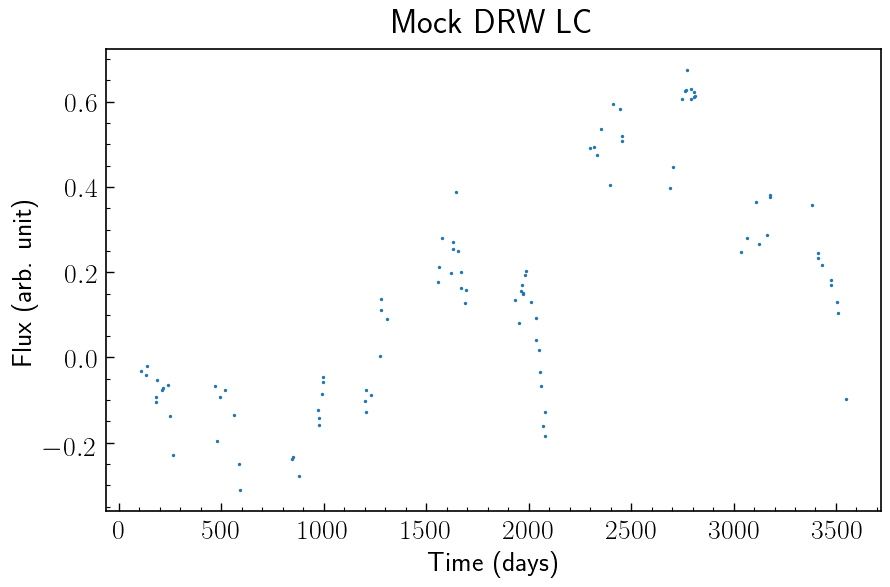

In [60]:
# plot
plt.scatter(t, y, s=2)
plt.title('Mock DRW LC')
plt.xlabel('Time (days)')
plt.ylabel('Flux (arb. unit)')

#### 1.2 MCMC for the LL surface and make contour plot

In [61]:
import emcee
import corner

In [62]:
def neg_log_like(params, y, yerr, gp):
    params = np.array(params)
    # pure likelihood based
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

def log_like(params):
    params = np.array(params)
    # pure likelihood based
    gp.set_parameter_vector(params)
    return gp.log_likelihood(y)

vec_neg_log_like = np.vectorize(neg_log_like, excluded=[1,2,3], signature='(n)->()')

In [63]:
init_tau = np.exp(np.random.uniform(1, np.log(700), 1)[0])
init_amp = np.random.uniform(0, 0.35, 1)[0]

kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
gp_fit = GP(kernel_fit)
gp_fit.compute(t, yerr)

initial_params = gp_fit.get_parameter_vector()
bounds = gp_fit.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, \
             args=(y, yerr, gp_fit))

initial_best = r.x
print(f'Optimized Soln: {r.x}')

Optimized Soln: [-1.25004374  6.09344528]


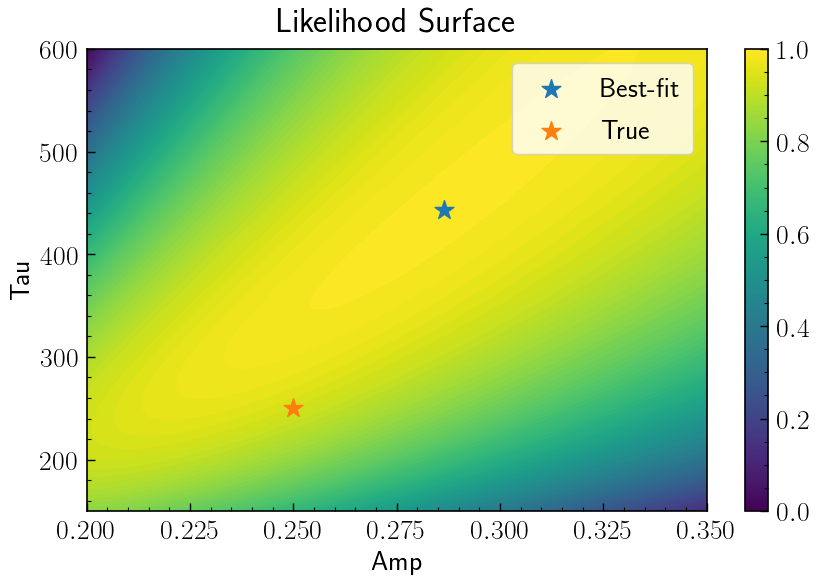

In [67]:
plot_drw_ll(t, y, yerr, np.exp(r.x), gp_fit, vec_neg_log_like, amp_range=[0.2, 0.35], tau_range=[150, 600], true_params=[0.25, 250])

In [68]:
initial = np.array(r.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_like)

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler.run_mcmc(p0, 500)

print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);

Running burn-in...
Running production...


In [69]:
percent_3 = np.percentile(sampler.flatlnprobability, 5)
selected_samples = sampler.flatchain[sampler.flatlnprobability > percent_3]
selected_samples.shape

(60800, 2)

Text(0.5, 1.0, 'Distribution of MCMC walkers')

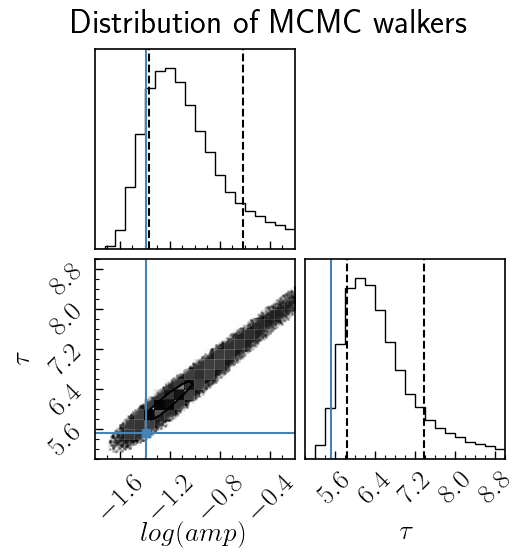

In [175]:
names = gp.get_parameter_names()
cols = kernel.get_parameter_names()
# fig = plt.figure(figsize=(8,6))
inds = np.array([names.index("kernel:"+k) for k in cols])
fig = corner.corner(selected_samples[:, inds], truths=np.log([0.25, 250]), \
              labels=['$log(amp)$', '$\\tau$'], range=[(-1.8, -0.2), (5, 9)],\
              quantiles=[0.159, 0.841], levels=(1-np.exp(-0.5),));
fig.suptitle('Distribution of MCMC walkers',y = 1.)

### 2. ABC with MCMC sampling
This part will use Approximate Bayesian Computation to invesigate if the observed likelihood probability distribution correctly mimic the distribution of true parameters. Instead of using an uniform prior, we will use MCMC to speed up sampling. 

For each round of simulation, we pick one set of parameters -> simulate LC (with same sampling as in section 1.) -> and fit this LC to get the best-fit params -> use the distance (squared) from this round of best-fit params to that obtained in section 1. as a form of likelihood. The final goal is to probe the distribution of DRW parameters that can result in the best-fit parameters close enough to the values obtain above.

In [131]:
def log_abc_prob(params, gp, gp_fit):
    
    distance = []
    params = np.array(params)
    run = True
    if (params[0] > -0.4) or (params[1] > 7):
        return -np.inf
    
    gp.set_parameter_vector(params)
    gp.compute(t, yerr)

    while run:
        try:
            new_y = gp.sample()

            init_tau = np.exp(np.random.uniform(1, np.log(700), 1)[0])
            init_amp = np.random.uniform(0, 0.35, 1)[0]
            gp_fit.set_parameter_vector(np.log([init_amp, init_tau]))

            initial_params = gp_fit.get_parameter_vector()
            bounds = gp_fit.get_parameter_bounds()

            r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, \
                     args=(new_y, yerr, gp_fit))
            run = False
        except celerite.solver.LinAlgError as e:
            print(e)
            continue
        
#         distance.append(np.sqrt(np.sum((r.x - initial_best)**2)))
    
    distance = np.sqrt(np.sum((r.x - initial_best)**2))
    return -distance**2

vec_log_abc_prob = np.vectorize(log_abc_prob, excluded=[1,2], signature='(n)->()')

In [136]:
initial_abc = np.array(initial_best)
ndim, nwalkers = len(initial), 32
sampler_abc = emcee.EnsembleSampler(nwalkers, ndim, log_abc_prob, args=[gp, gp_fit])

print("Running burn-in...")
p0 = initial + 1e-8 * np.random.randn(nwalkers, ndim)
p0, lp, _ = sampler_abc.run_mcmc(p0, 500)

print("Running production...")
sampler_abc.reset()
sampler_abc.run_mcmc(p0, 1500);

Running burn-in...


/home/conda/lib/python3.7/site-packages/scipy/optimize/_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


failed to factorize or solve matrix
failed to factorize or solve matrix
Running production...
failed to factorize or solve matrix
failed to factorize or solve matrix
failed to factorize or solve matrix
failed to factorize or solve matrix
failed to factorize or solve matrix
failed to factorize or solve matrix
failed to factorize or solve matrix


Best-fit Sol: [-1.25004374  6.09344528]


Text(0.5, 1, 'Distribution of true parameters obtained by ABC')

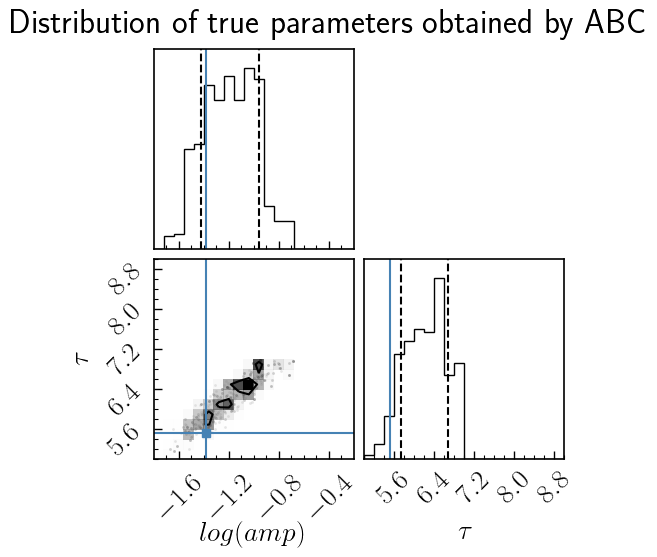

In [174]:
print(f'Best-fit Sol: {initial_best}')
fig = corner.corner(sampler_abc.flatchain[sampler_abc.flatlnprobability > -0.01, :], \
              truths=np.log([0.25, 250]), labels=['$log(amp)$', '$\\tau$'], \
              range=[(-1.8, -0.2), (5, 9)], quantiles=[0.159, 0.841], levels=(1-np.exp(-0.5),));
fig.suptitle('Distribution of true parameters obtained by ABC', y=1)
# corner.corner(sampler_abc.flatchain[sampler_abc.flatlnprobability > -0.001, :], labels=['$log\_{amp}$', '$\\tau$']);

<span style='color:red'>__Conclusion:__</span> It seems like the likelihood probablilty is a good approximation of the distribution of the true parameters. 

In [33]:
## Code for uniform sampling

# param_samples = np.log(np.random.uniform(low=[0.1, 50], \
#                                   high=[0.36, 400], size=(400, 2)))

# neg_dist = vec_log_abc_prob(param_samples, gp, gp_fit)

# neg_dist_flat = neg_dist.flatten()
# params_repeat = np.repeat(param_samples, 50, axis=0)

# keep_repeat = neg_dist_flat > -0.08

# corner.corner(params_repeat[keep_repeat, :], truths=np.log([0.25, 250]), labels=['$log\_{amp}$', '$\\tau$']);

In [256]:
# # Code for checking the distribution of driving amplitude
# close_sets = param_samples[keep, :]
# sigma = np.exp((2*close_sets[:,0]+np.log(2)-close_sets[:,1])/2)
# _ = plt.hist(sigma, histtype='step', bins='fd')
# plt.vlines(np.sqrt(0.25**2*2/200), 0, 10)